## Introduction:
With the advancement in technology,the e-commerce business is quite popular today. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra.
## Objective:
Our main goal is to build a model that will improve the recommendations given to the users given their past reviews and ratings in order to grow the e-commerce business. For this we will build a sentiment-based product recommendation system.
## Assumptions:
The number of users and the number of products are fixed in this case study, and we are doing the sentiment analysis and building the recommendation system only for those users who have already submitted the reviews or ratings corresponding to some of the products in the dataset. In other words, no new users or products will be introduced or considered when building or predicting from the models built.

In [1]:
# import general libraties for data processing and visualization:
import re
import time
import math
import pandas as pd
import numpy as np
import copy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import NLTK libraries for natural language processing:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# import libraries for model building and model evalution:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.metrics import auc, plot_roc_curve

### Data sourcing:

In [4]:
# main_df = pd.read_csv(r'C:\Users\ADMIN\Downloads\sample30.csv', encoding='latin-1')
# main_df.head()

In [5]:
main_df = pd.read_pickle(r'C:\Users\ADMIN\Downloads\sample30.pkl')
main_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### EDA and visualization:

In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
df_attributes = pd.read_csv(r'C:\Users\ADMIN\Downloads\Data+Attribute+Description.csv', encoding='latin-1')
with pd.option_context('display.max_colwidth', None):
    display(df_attributes)

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


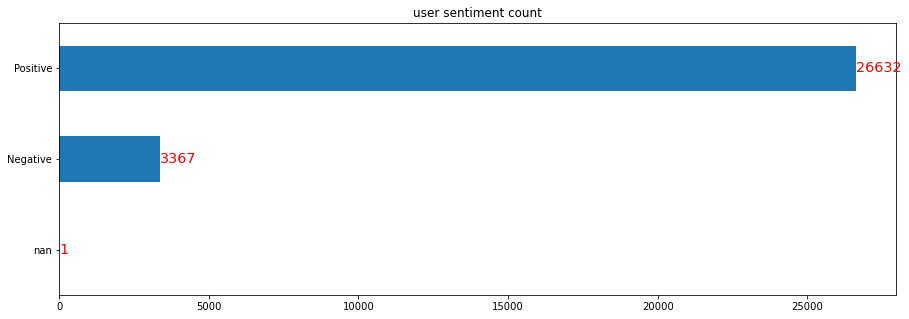

In [8]:
plt.figure(figsize = (15,5))
main_df.user_sentiment.value_counts(dropna=False).sort_values().plot(kind = 'barh')
for index, value in enumerate(main_df.user_sentiment.value_counts(dropna=False).sort_values().values):
    plt.text(value, index, str(value),verticalalignment='center',color='r',fontsize ='x-large')
plt.title('user sentiment count')
plt.show()

`We can see that we have class imbalance issue.`

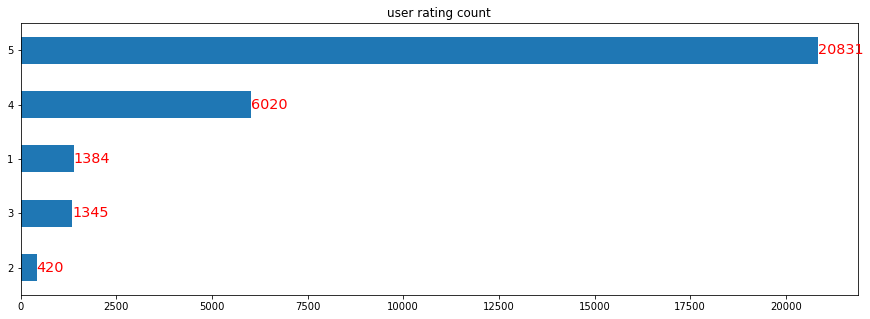

In [9]:
plt.figure(figsize = (15,5))
main_df.reviews_rating.value_counts(dropna=False).sort_values().plot(kind = 'barh')
for index, value in enumerate(main_df.reviews_rating.value_counts(dropna=False).sort_values().values):
    plt.text(value, index, str(value),verticalalignment='center',color='r',fontsize ='x-large')
plt.title('user rating count')
plt.show()

`Most of the ratings are 5-stars where as 2-stars are given the least number of times.`

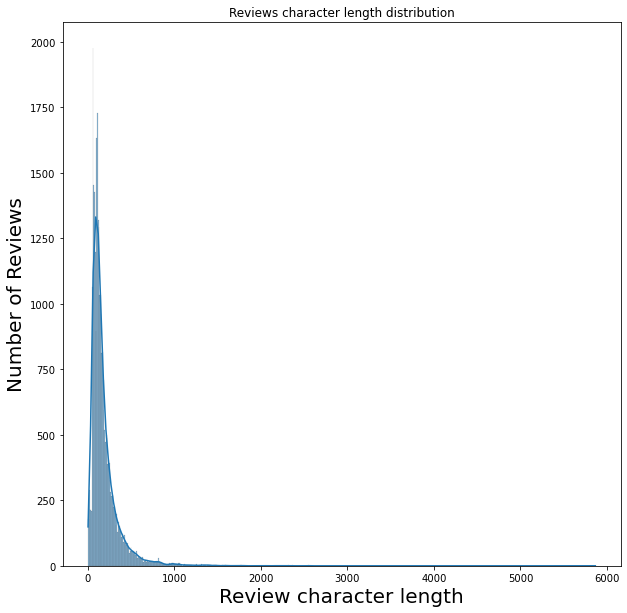

In [10]:
# Reviews character length distribution
review_len = [len(review) for review in main_df['reviews_text']]

plt.figure(figsize=(10,10))
sns.histplot(data=review_len,kde=True)
plt.ylabel('Number of Reviews', fontsize=20)
plt.xlabel('Review character length', fontsize=20)
plt.title('Reviews character length distribution')
plt.show()

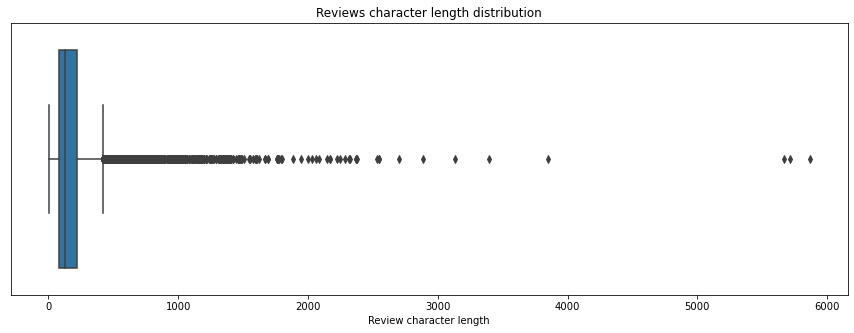

In [11]:
plt.figure(figsize=[15,5])
sns.boxplot(data=review_len,orient='h')
plt.yticks([])
plt.xlabel('Review character length')
plt.title('Reviews character length distribution')
plt.show()

`From the boxplot and histogram we can see that Reviews character length distribution is highly right skewed.`

In [12]:
print(f'Total unique product categories are : {main_df.categories.nunique(dropna=False)}')
print(f'Total unique product brands are : {main_df.brand.nunique(dropna=False)}')
print(f'Total unique products are : {main_df.name.nunique(dropna=False)}')

Total unique product categories are : 270
Total unique product brands are : 214
Total unique products are : 271


# sentiment-based product recommendation system
* As per our problem statement we need to build two different models:
    1. Product recommendation model
    2. Sentiment classification model

## Task 1. Building collaborative filtering based product recommendation system:

* Types of collaborative filtering based recommendation systems:
    1. User-based recommendation system
        * In user-based collaborative filtering, user will be recommended items that have been liked by other users who share similar tastes and preferences.
    2. Item-based recommendation system
        * Item-based recommendation filtering recommends items that are similar to the items that user may have already rated or liked/disliked. 

* we will consider following relevent columns for building product recommendation model:
    * reviews_username :- individual's unique username.
    * reviews_rating :- rating given by the user to a particular product.
    * name :- name of the product

In [13]:
main_df_filtered = main_df.copy(deep=True)
main_df_filtered.drop(columns=['id','reviews_date','reviews_didPurchase','reviews_doRecommend','reviews_userCity','reviews_userProvince'],inplace=True)
main_df_filtered.head()

,brand,categories,manufacturer,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [14]:
# Checking for duplicate rows:
main_df_filtered.duplicated().sum()

279

In [15]:
# Droping duplicate rows since they will not contribute any additional useful information. 
main_df_filtered.drop_duplicates(inplace=True)

Consider a scenario where user 'A' rates same product 'P' twice with same rating 'R' but with different reviews 'R1' and 'R2'. For the purpose of building recommendation system, these two records will be logically duplicate and thus will not offer any information diversity. This is because for building recommendation system, we only consider rating given by a particular user to a particular product. thus, review attribute will be irrelevent as long as 'A', 'P' and 'R' are same. On the other hand later in sentiment classification, review attribute will play major role.

In [16]:
# Further inspecting duplicate values by above mentioned logic:
main_df_filtered.duplicated(subset=['brand','categories','manufacturer','name','reviews_rating','reviews_username']).sum()

1958

In [17]:
# Droping duplicate values due to above mentioned logic:
main_df_filtered.drop_duplicates(subset=['brand','categories','manufacturer','name','reviews_rating','reviews_username'],inplace=True)

In [18]:
main_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27763 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   brand             27763 non-null  object
 1   categories        27763 non-null  object
 2   manufacturer      27622 non-null  object
 3   name              27763 non-null  object
 4   reviews_rating    27763 non-null  int64 
 5   reviews_text      27763 non-null  object
 6   reviews_title     27577 non-null  object
 7   reviews_username  27739 non-null  object
 8   user_sentiment    27762 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


In [19]:
# Filtering dataframe resulting in relevent attributes only:
main_df_filtered = main_df_filtered[['reviews_username','name','reviews_rating']]

In [20]:
main_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27763 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  27739 non-null  object
 1   name              27763 non-null  object
 2   reviews_rating    27763 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 867.6+ KB


In [21]:
# Inspecting few records containg null value in 'reviews_username' column:
main_df_filtered[main_df_filtered.isnull().any(axis=1)][:10]

,reviews_username,name,reviews_rating
1453,NaN,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,4
1531,NaN,Yes To Carrots Nourishing Body Wash,5
1787,NaN,Clambake (dvd),2
1792,NaN,Clambake (dvd),4
1795,NaN,Clambake (dvd),5
3472,NaN,Toy Story Kids' Woody Accessory Kit,1
4152,NaN,Hoover174 Platinum Collection153 Lightweight B...,1
4168,NaN,Hoover174 Platinum Collection153 Lightweight B...,2
4230,NaN,Hoover174 Platinum Collection153 Lightweight B...,4
4473,NaN,Hoover174 Platinum Collection153 Lightweight B...,5


In [22]:
main_df_filtered.isnull().sum()

reviews_username    24
name                 0
reviews_rating       0
dtype: int64

It is not clear whether these records correspond to single or distinct users. Since number of such records with missing username is low, We will drop these records instead of imputation, to avoid introducing any bias/misinformation to the dataset.

In [23]:
main_df_filtered.dropna(inplace=True)
main_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27739 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  27739 non-null  object
 1   name              27739 non-null  object
 2   reviews_rating    27739 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 866.8+ KB


In [24]:
# Checking for duplicates in final filtered dataframe:
main_df_filtered.duplicated().sum()

0

#### Train-Test data split:

In [25]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(main_df_filtered, test_size=0.30, random_state=10)

print(train.shape)
print(test.shape)

(19417, 3)
(8322, 3)


### 1.1 User-based recommendation system:

In [26]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are usernames.
df_pivot = train.pivot_table( 
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc = 'mean'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train & dummy test dataset

- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. In other words we will place ‘1’ where there is no rating present and ‘0’ where there are ratings.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [27]:
# Copy the train dataset into dummy_train
dummy_train = train.copy(deep=True)
dummy_train.head()

,reviews_username,name,reviews_rating
7864,azchick,Clorox Disinfecting Wipes Value Pack Scented 1...,4
13478,auntieanna,Clorox Disinfecting Wipes Value Pack Scented 1...,5
5356,ezmny,The Resident Evil Collection 5 Discs (blu-Ray),5
29081,cricri,L'or233al Paris Elvive Extraordinary Clay Reba...,4
27318,dennis,Planes: Fire Rescue (2 Discs) (includes Digita...,4


In [28]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [29]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc = 'mean'
).fillna(1)

In [30]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Using cosine similarity:
Since the matrix is very sparse matrix i.e. most of the users have rated a single product only, thus, in this case adjusted cosine does not exist for such users with themselves. `Thus we have used the cosine similarity to get the similarity between the users for simplicity.`
* cosine similarity - If the angle between their respective vectors is less, then there will be more similarity between the users, and if the angle between the vectors is more, then there will be less similarity between those users.


In [31]:
df_pivot.index.nunique()

17849

In [32]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [33]:
user_correlation.shape

(17849, 17849)

### Prediction - User based Collaborative Filtering

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [34]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [35]:
#this is dot product of corelated matrix and user-iiem matrix
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  1.66297526,
         0.        ,  0.        ],
       [ 0.        ,  1.80722895,  0.        , ..., 12.33229865,
         2.73861279,  1.35506186],
       [ 0.        , 28.40663797,  0.        , ..., 20.60501165,
         0.        ,  0.48867778],
       ...,
       [ 0.        ,  8.27280174,  0.        , ...,  7.34581196,
         2.62071209,  0.        ],
       [ 0.        ,  0.73507667,  0.        , ..., 10.31471615,
         2.88675135,  1.22474487],
       [ 0.        ,  8.27280174,  0.        , ...,  7.34581196,
         2.62071209,  0.        ]])

In [36]:
user_predicted_ratings.shape

(17849, 253)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

In [37]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.461830,...,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,1.662975,0.000000,0.000000
00sab00,0.0,1.807229,0.0,0.0,2.738613,0.0,0.0,0.0,0.0,1.689575,...,0.0,0.00000,0.0,2.240496,0.420239,0.0,0.0,12.332299,2.738613,1.355062
01impala,0.0,28.406638,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,6.706415,...,0.0,2.46183,0.0,2.051823,1.495025,0.0,0.0,20.605012,0.000000,0.488678
02dakota,0.0,28.406638,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,6.706415,...,0.0,2.46183,0.0,2.051823,1.495025,0.0,0.0,20.605012,0.000000,0.488678
02deuce,0.0,28.406638,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,6.706415,...,0.0,2.46183,0.0,2.051823,1.495025,0.0,0.0,20.605012,0.000000,0.488678


### Finding the top 20 recommendation for the *user*

In [38]:
# Take the username as input.
user_input = input("Enter your user name")
print(user_input)

01impala


To find the top 20 products for a particular user, you have to filter out the highest rating from ‘user_final_rating’ for a particular user.

In [39]:
UBCF_top20 = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
UBCF_top20

name
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                110.747462
Mike Dave Need Wedding Dates (dvd + Digital)                                        86.532154
The Resident Evil Collection 5 Discs (blu-Ray)                                      80.944372
Red (special Edition) (dvdvideo)                                                    58.303749
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                           52.676001
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                52.408303
Clorox Disinfecting Bathroom Cleaner                                                30.670025
100:Complete First Season (blu-Ray)                                                 28.406638
Chester's Cheese Flavored Puffcorn Snacks                                           24.054347
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                               20.605012
Coty Airspun Face Powder, Translucent Extra Coverage   

# Evaluation - User based Collaborative Filtering
To evaluate the user-based recommendation system, we need to extract those users from the ‘test’ and ‘dummy_test’ datasets that are present in the train dataset because we can find the predicted ratings only for those users. And, only then, we can find the error between the predicted and the actual ratings.

Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [40]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1108, 3)

In [41]:
common.head(3)

,reviews_username,name,reviews_rating
7266,ayterrazas,Clorox Disinfecting Wipes Value Pack Scented 1...,4
17574,lisa,Mill Creek Aloe Vera & Paba Lotion,5
5041,radicxs2,The Resident Evil Collection 5 Discs (blu-Ray),5


In [42]:
# convert into the user-item matrix.
common_user_based_matrix = common.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating',
    aggfunc = 'mean')

In [43]:
common_user_based_matrix.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.87E+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
common_user_based_matrix.shape

(907, 120)

In [45]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [46]:
user_correlation_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [47]:
user_correlation_df.shape

(17849, 17849)

In [48]:
df_pivot.shape

(17849, 253)

In [49]:
# Set index of user_correlation df as index of df_pivot
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [50]:
user_correlation_df.shape

(17849, 17849)

Filter out correlations of those users that are common in both train and test datasets :

In [51]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_pivot.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

'user_correlation_df_3' is a correlation matrix of only those users that are common in both test and train datasets.

In [52]:
user_correlation_df_3.head(3)

,1234,123charlie,37f5p,7.87E+11,aaron,acg1,adam,adelynsmom,adrienne,aep1010,...,woottos,wvshopaholic,xavier,xmom,yohnie1,yummy,zach,zipper,zippy,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.780869,0.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.624695,...,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0
123charlie,0.780869,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
37f5p,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0


In [53]:
user_correlation_df_3.shape

(907, 907)

let’s now find out the predicted ratings of the test dataset using the ‘user_correlation_df_3’ and ‘common_user_based_matrix’ matrices. This operation is exactly the same as the one we performed for the train dataset to predict the ratings.Then, we need to perform a dot product between the ‘user_correlation_df_3’ and ‘common_user_based_matrix’ matrices.

In [54]:
# change negative values of the correlation matrix to 0:
user_correlation_df_3[user_correlation_df_3<0]=0

# a dot product between the ‘user_correlation_df_3’ and ‘common_user_based_matrix’ matrices:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  1.80333927,  0.        , ...,  7.80662951,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  3.53553391,
         0.        ,  0.        ],
       [ 2.5       , 10.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  5.27420375,  0.        , ...,  8.53553391,
         0.        ,  0.        ],
       [ 0.        ,  5.38338879,  0.        , ...,  2.90848228,
         1.49926811,  2.4       ],
       [ 0.        ,  0.        ,  0.        , ...,  5.        ,
         3.12347524,  0.        ]])

To get the predicted ratings of those users who have already rated the products, we will copy a common dataframe and give the rating value 1 to those who rated the product and 0 to those who did not. Then, we will multiply dummy_test with the common_user_predicted_ratings matrix to get the common_user_predicted_ratings dataframe

In [55]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating',
    aggfunc = 'mean').fillna(0)

In [56]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [57]:
common_user_predicted_ratings.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. 
To calculate RMSE, we need to normalise the rating such that its range is between 1 and 5.

In [58]:
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan  5. nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [59]:
common_ = common.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating')

In [60]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [61]:
UBCF_rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(UBCF_rmse)

2.160174168304947


In [62]:
rmse_df = pd.DataFrame({'type':['UBCF'],'rmse':[round(UBCF_rmse,2)]})
rmse_df

,type,rmse
0,UBCF,2.16


### 1.2 Item-based recommendation system:

To get a `product vs user matrix` instead of a user vs product matrix,we take the transpose of the rating matrix.

In [63]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`We will use the cosine similarity to get the similarity between the items.`

In [64]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [65]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [66]:
item_correlation.shape

(253, 253)

To predict products for a particular user, we need to get the predicted rating matrix. The predicted rating for the users (for rated as well as non-rated products) is the weighted sum of correlation with the product rating. Hence, we need to perform matrix multiplication for the two matrices: ‘df_pivot’ and ‘item_correlation’.

In [67]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.07085904, 0.        ,
        0.        ],
       [0.        , 0.01784224, 0.        , ..., 0.05496796, 0.02495488,
        0.02222441],
       [0.        , 0.07065269, 0.        , ..., 0.04528661, 0.        ,
        0.00246631],
       ...,
       [0.        , 0.02554392, 0.        , ..., 0.01106976, 0.01109656,
        0.        ],
       [0.        , 0.01351655, 0.        , ..., 0.06638567, 0.04159146,
        0.03347037],
       [0.        , 0.02043513, 0.        , ..., 0.00885581, 0.00887725,
        0.        ]])

In [68]:
item_predicted_ratings.shape

(17849, 253)

In [69]:
dummy_train.shape

(17849, 253)

### Filtering the rating only for the products not rated by the user for recommendation:
Since we are interested only in the products that are not rated by the user, we will ignore the products rated by the user by changing the ratings to zero. This operation can be performed using the ‘dummy_train’ dataset that we created earlier. We need to multiply each element of the ‘dummy_train’ dataset with the ‘item_predicted_ratings’ matrix, and then, we get the ‘item_final_rating’ matrix.

In [70]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.081790,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.070859,0.000000,0.000000
00sab00,0.0,0.017842,0.0,0.0,0.157275,0.0,0.0,0.0,0.0,0.010345,...,0.0,0.000000,0.0,0.054780,0.013993,0.0,0.0,0.054968,0.024955,0.022224
01impala,0.0,0.070653,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016542,...,0.0,0.044706,0.0,0.026525,0.022655,0.0,0.0,0.045287,0.000000,0.002466
02dakota,0.0,0.117754,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.027570,...,0.0,0.074509,0.0,0.044208,0.037758,0.0,0.0,0.075478,0.000000,0.004111
02deuce,0.0,0.094204,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.022056,...,0.0,0.059608,0.0,0.035366,0.030206,0.0,0.0,0.060382,0.000000,0.003288


### Finding the top 20 recommendation for the *user*



In [71]:
# Take the user name as input
user_input = input("Enter your user name")
print(user_input)

01impala


To find the top 20 products for a particular user, we have to filter out the highest rating from 'item_final_rating' for a particular user.

In [72]:
# Recommending the Top 20 products to the user.
IBCF_top20 = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
IBCF_top20

name
Mike Dave Need Wedding Dates (dvd + Digital)                                      0.101818
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               0.094013
The Resident Evil Collection 5 Discs (blu-Ray)                                    0.083409
100:Complete First Season (blu-Ray)                                               0.070653
Red (special Edition) (dvdvideo)                                                  0.070225
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                              0.066451
Cetaphil Gentle Skin Cleanser, 2oz                                                0.059519
Chester's Cheese Flavored Puffcorn Snacks                                         0.058770
Various - Country's Greatest Gospel:Gold Ed (cd)                                  0.057945
Batherapy Natural Mineral Bath Sport Liquid, 16 oz                                0.051217
Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer    0.0

# Evaluation - Item based Collaborative Filtering
To evaluate the item-based recommendation system, we need to extract those products from the ‘test’ and ‘dummy_test’ datasets that are present in the train dataset because we can find the predicted ratings only for those products. And, only then, we can find the error between the predicted and the actual ratings.

Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the products already rated by the user instead of predicting it for the products not rated by the user. 

In [73]:
test.columns

Index(['reviews_username', 'name', 'reviews_rating'], dtype='object')

In [74]:
# Find out the common users of test and train dataset.
common =  test[test.name.isin(train.name)]
common.shape

(8301, 3)

In [75]:
common.head(4)

,reviews_username,name,reviews_rating
27303,jakepogo1,Planes: Fire Rescue (2 Discs) (includes Digita...,4
7266,ayterrazas,Clorox Disinfecting Wipes Value Pack Scented 1...,4
12658,itbklc,Clorox Disinfecting Wipes Value Pack Scented 1...,5
4066,student on the way to organization,"Pendaflex174 Divide It Up File Folder, Multi S...",5


In [76]:
# convert into the product-user rating matrix.
common_item_based_matrix = common.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating').T

In [77]:
common_item_based_matrix.shape

(197, 7953)

In [78]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)

In [79]:
item_correlation_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Set index of item_correlation df as index of df_pivot
item_correlation_df['name'] = df_pivot.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15867,0.0


We will now filter out the correlation of only those products that are common in both test and train datasets:

In [81]:
list_name = common.name.tolist()
item_correlation_df.columns = df_pivot.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

'item_correlation_df_3' is a correlation matrix of only those products that are common in both test and train datasets.

In [82]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


let’s find out the predicted ratings of the test dataset using the ‘item_correlation_df_3’ and ‘common_item_based_matrix’ matrices. This operation is exactly the same as the one that we performed for the train dataset to predict the ratings. So, first, we need to change the negative values of the correlation matrix to 0. Then, we need to perform a dot product between the ‘item_correlation_df_3’ and ‘common_item_based_matrix’ matrices.

In [83]:
# change negative values of the correlation matrix to 0:
item_correlation_df_3[item_correlation_df_3<0]=0

# a dot product between the ‘item_correlation_df_3’ and ‘common_item_based_matrix’ matrices:
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02554392, 0.02554392, 0.12552782, ..., 0.        , 0.11775449,
        0.05346773],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01106976, 0.01106976, 0.11230549, ..., 0.        , 0.07547768,
        0.02954288],
       [0.01109656, 0.01109656, 0.04626579, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00328841, ..., 0.        , 0.00411052,
        0.        ]])

In [84]:
common_item_predicted_ratings.shape

(197, 7953)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. 
* To get the predicted ratings of those users who have already rated the products, we will copy a common dataframe and give the rating value 1 to those who rated the product and 0 to those who did not (This is just opposite of dummy_train). Then, we will multiply dummy_test with the common_user_predicted_ratings matrix to get the common_user_predicted_ratings dataframe

In [85]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

Calculating the RMSE for only the products rated by user. 
To calculate RMSE, we need to normalise the rating such that its range is between 1 and 5.

In [86]:
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [87]:
common_ = common.pivot_table(
    index='reviews_username', 
    columns='name', 
    values='reviews_rating').T

In [88]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [89]:
IBCF_rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(IBCF_rmse)

3.5885351853421494


In [90]:
IBCF_info = {'type':'IBCF','rmse':round(IBCF_rmse,2)}
rmse_df = rmse_df.append(IBCF_info,ignore_index=True)
print(rmse_df)

   type  rmse
0  UBCF  2.16
1  IBCF  3.59


#### Conclusion:
We will finalize User-Based Collaborative Filtering method as it is giving better results i.e. lower rmse score.

In [91]:
# Saving UBCF model ('user_final_rating' matrix) with the help of pickle.
with open('./Model/recommendation_UBCF.pkl', 'wb') as file_1:
    pickle.dump(user_final_rating, file_1)

## Task 2. Building Sentiment classification model:
* For building classification model we will try following types of ML classification models and select the one which is giving better results: 
    1. Logistic regression
    2. Random forest
    3. Naive Bayes
    4. XGBoost

* we will consider following relevent columns for building a sentiment classification model:
    * reviews_text : review given by the user to a particular product.
    * reviews_title : The title of the review given by the user to a particular product.
    * user_sentiment : The overall sentiment of the user for a particular product (Positive or Negative)

Since these attributes are textual in nature, we will have to take the help of `natural language processing`. For this we will use `nltk module`. 

In [92]:
# Filtering out relevent columns only for classification:
review_filtered = main_df[['name','reviews_text','reviews_title','user_sentiment']].copy(deep=True)

In [93]:
review_filtered.head(2)

,name,reviews_text,reviews_title,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Just Awesome,Positive
1,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Good,Positive


In [94]:
review_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            30000 non-null  object
 1   reviews_text    30000 non-null  object
 2   reviews_title   29810 non-null  object
 3   user_sentiment  29999 non-null  object
dtypes: object(4)
memory usage: 937.6+ KB


In [95]:
review_filtered.user_sentiment.value_counts(dropna=False)

Positive    26632
Negative     3367
NaN             1
Name: user_sentiment, dtype: int64

In [96]:
# Inspecting the null value record
with pd.option_context('display.max_colwidth', None):
    display(review_filtered[pd.isnull(review_filtered.user_sentiment)])

,name,reviews_text,reviews_title,user_sentiment
28354,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN


In [97]:
# Imputing the null value:
review_filtered.loc[28354,'user_sentiment'] = 'Positive'
review_filtered.user_sentiment.value_counts(dropna=False)

Positive    26633
Negative     3367
Name: user_sentiment, dtype: int64

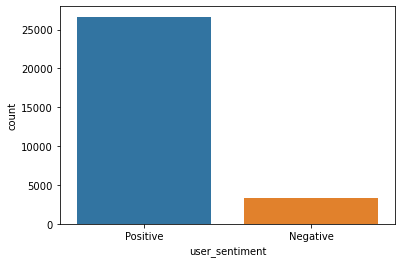

In [98]:
sns.countplot(x = 'user_sentiment', data = review_filtered)
plt.show()

In [99]:
review_filtered.isnull().sum()

name                0
reviews_text        0
reviews_title     190
user_sentiment      0
dtype: int64

#### Text preprocessing

Since our data is unstructred text, we need to perform certian Text preprocessing before feeding it to any model. Basically we try to reduce the noise in the data(e.g. removing punctuations) as well as standardize the format(e.g. making all words lower case).

We will perform following preprocessing steps:
* Remove any unwanted text (noise).
* Make the text lowercase
* Remove punctuation
* Remove words containing non-ascii and digits
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [100]:
"""Basic cleaning of texts."""
def scrub_words(text):
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text = text.strip()
    text = re.sub(' +', ' ',text)
    
    return text

In [101]:
"""POS tagging"""
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [102]:
"""Text lemmatizing"""
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [103]:
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

In [104]:
negative_words = set(["no","nor","not"])
stop = set([word for word in stop if word not in negative_words])

In [105]:
def preprocessing(x):
    # Breaking negative words e.g. can't : can not
    x['reviews_text'] = x['reviews_text'].replace(r"\'t", " not", regex=True)
    x['reviews_title'] = x['reviews_title'].replace(r"\'t", " not", regex=True)
    # Replace nan value with empty string:
    x['reviews_title'] = x['reviews_title'].replace(np.nan, '', regex=True) 
    # Concate review text and review title columns:
    x['combined_txt'] = x['reviews_text'] + ' ' + x['reviews_title']
    # Remove unwanted text/noise:
    x['combined_txt'] = x['combined_txt'].str.replace(r'This review was collected as part of a promotion.', '', regex=False,case=False)
    # Replace punctuations with empty string:
    x['combined_txt'] = x['combined_txt'].str.replace('[^\w\s]','',regex=True)
    # Lowercase the text:
    x['combined_txt'] = x['combined_txt'].str.lower()
    # Remove stop words:
    x['combined_txt'] = x['combined_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    # Remove non-ascii words, digits and unnecessary white spaces:
    x['combined_txt'] = x['combined_txt'].apply(scrub_words)
    # Lemmatizing words:
    x['combined_txt'] = x['combined_txt'].apply(lemmatize_sentence)

In [106]:
# Preprocessing text:
preprocessing(review_filtered)

In [107]:
review_filtered.head(7)

,name,reviews_text,reviews_title,user_sentiment,combined_txt
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Just Awesome,Positive,love album good hip hop side current pop sound...
1,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Good,Positive,good flavor good
2,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Good,Positive,good flavor good
3,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Disappointed,Negative,read review look buy one couple lubricant ulti...
4,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Irritation,Negative,husband buy gel us gel caused irritation felt ...
5,K-Y Love Sensuality Pleasure Gel,My boyfriend and I bought this to spice things...,Not worth it,Negative,boyfriend buy spice thing bedroom highly disap...
6,K-Y Love Sensuality Pleasure Gel,Bought this earlier today and was excited to c...,Disappointing,Negative,buy earlier today excite check base product de...


In [108]:
# Saving preprocessed dataframe with the help of pickle.
with open('./Data/preprocessed_df.pkl', 'wb') as doc:
    pickle.dump(review_filtered, doc)

Wordcloud of top 40 words by their frequency:

In [109]:
# Function to find top 40 words by frequency among all the reviews
def top_words(text,top_n=40):  
    review_words = text.str.split().values.tolist()
    all_words = [word for review in review_words for word in review]
    top_words = nltk.FreqDist(all_words).most_common(top_n)
    return top_words

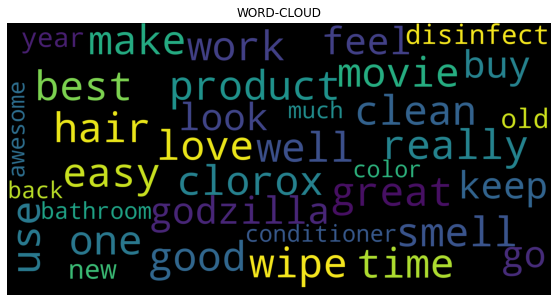

In [110]:
# plotting a word cloud to display the top 40 words by their frequency :
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color = 'black', width = 2000, height = 1000,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 150, contour_color = 'steelblue',
                      random_state = 0,collocations=False)
wordcloud.generate(' '.join([w for w,_ in top_words(review_filtered['combined_txt'])]))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('WORD-CLOUD')
plt.show()

In [111]:
# mapping class to an integer value:
review_filtered['sentiment_class']=review_filtered['user_sentiment'].map({'Negative':0,'Positive':1})

In [112]:
# Getting predictor and target variables:
x=review_filtered['combined_txt'] 
y=review_filtered['sentiment_class']

In [113]:
# Getting percentage of class imbalance:

no_of_classes= len(pd.Series(y).value_counts())

#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
  print("Percent of class {0}: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of class 0:  11.22 %
Percent of class 1:  88.78 %


`We have highly imbalanced data.`

In [114]:
# Train-Test split:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)
X_train_copy, X_test_copy, y_train_copy, y_test_copy = X_train.copy(deep=True), X_test.copy(deep=True), y_train.copy(deep=True), y_test.copy(deep=True)

#### Feature extraction

Now we will Convert the raw texts to a matrix of TF-IDF features.For this we will use off the shelf TfidfVectorizer available in sklearn.feature_extraction.text module.

In [115]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'.
    min_df=3,                   # Ignore terms that have a document frequency strictly lower than the given threshold.
    max_df=0.95,                # Ignore terms that have a document frequency strictly higher than the given threshold .
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    # stop_words='english',       # 'english' means 'ignore all the stop words specific to english language'.`
    sublinear_tf=True)           # Apply sublinear tf scaling

word_vectorizer.fit(X_train)    # Fiting it on Train
train_word_features = word_vectorizer.transform(X_train)  # Transform on Train

Saving word vectorizer model with the help of pickle:

In [116]:
with open('./Model/tfidf_vectorizer.pkl', 'wb') as file_2:
    pickle.dump(word_vectorizer, file_2)

In [117]:
## transforming the train and test datasets
X_train_transformed = word_vectorizer.transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())

# # Print the shape of each dataset.
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (21000, 36202)
y_train (21000,)
X_test_transformed (9000, 36202)
y_test (9000,)


###    2.1.1. Building the Logistic Regression model without hyperparameter tuning (without handling class imbalance):

In [118]:
# Build the Logistic Regression model.
time1 = time.time()

logit = LogisticRegression()
logit.fit(X_train_transformed,y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.40 seconds


In [119]:
# Prediction Train Data
y_pred_train= logit.predict(X_train_transformed)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train))
print(classification_report(y_pred_train, y_train))

Logistic Regression accuracy 0.9134761904761904
              precision    recall  f1-score   support

           0       0.23      0.98      0.38       557
           1       1.00      0.91      0.95     20443

    accuracy                           0.91     21000
   macro avg       0.62      0.95      0.66     21000
weighted avg       0.98      0.91      0.94     21000



In [120]:
# Prediction Test Data
y_pred_test = logit.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.9015555555555556
              precision    recall  f1-score   support

           0       0.14      0.88      0.25       163
           1       1.00      0.90      0.95      8837

    accuracy                           0.90      9000
   macro avg       0.57      0.89      0.60      9000
weighted avg       0.98      0.90      0.93      9000

[[ 144   19]
 [ 867 7970]]


In [121]:
# Calculate F1 Score of tuned model using weighted average method
f1_logit_untuned_train = f1_score(y_train, y_pred_train, average="weighted")

f1_logit_untuned_test = f1_score(y_test, y_pred_test, average="weighted")

In [122]:
classification_model_performance = pd.DataFrame(
    {'Model':['logit_untuned'],
    'f1_score_train':[round(f1_logit_untuned_train,2)],
    'f1_score_test':[round(f1_logit_untuned_test,2)]})

In [123]:
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87


`Handling Class imbalance:`
For handling class imbalance issue, we will take help of 'SMOTE`. Synthetic Minority Oversampling Technique, or SMOTE is a type of data augmentation for the minority class. It synthesizes new samples for the minority class by oversampling the minority class.

In [124]:
counter = Counter(y_train)
print('Before',counter)

# creating instance of class smote of library imblearn:
sm = SMOTE()

# transform the dataset
X_train_transformed_sm, y_train_sm = sm.fit_resample(X_train_transformed, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 18644, 0: 2356})
After Counter({1: 18644, 0: 18644})


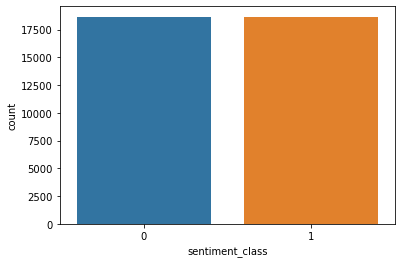

In [125]:
sns.countplot(x=y_train_sm)
plt.show()

We have handled the class imbalance.

###    2.1.2. Building the Logistic Regression model without hyperparameter tuning after handling class imbalance:

In [126]:
# Building the Logistic Regression model
time2 = time.time()

logit_sm = LogisticRegression()
logit_sm.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time2
print('Time Taken in logestic regression with smote: {:.2f} seconds'.format(time_taken))

Time Taken in logestic regression with smote: 0.37 seconds


In [127]:
# Prediction Train Data
y_pred_train= logit_sm.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Logistic Regression accuracy 0.9680057927483373
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     19391
           1       0.95      0.99      0.97     17897

    accuracy                           0.97     37288
   macro avg       0.97      0.97      0.97     37288
weighted avg       0.97      0.97      0.97     37288



In [128]:
# Prediction Test Data
y_pred_test = logit_sm.predict(X_test_transformed)

print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.8942222222222223
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      1315
           1       0.92      0.96      0.94      7685

    accuracy                           0.89      9000
   macro avg       0.80      0.74      0.76      9000
weighted avg       0.89      0.89      0.89      9000

[[ 687  628]
 [ 324 7361]]


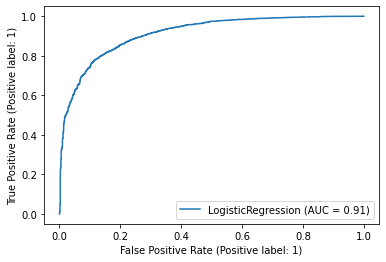

In [129]:
plot_roc_curve(logit_sm, X_test_transformed, y_test)
plt.show()

In [130]:
# Calculate F1 Score of tuned model using weighted average method
f1_logit_untuned_smote_train = f1_score(y_train_sm, y_pred_train, average="weighted")

f1_logit_untuned_smote_test = f1_score(y_test, y_pred_test, average="weighted")

In [131]:
logit_untuned_smote_dict = {'Model':'logit_untuned_smote',
    'f1_score_train':round(f1_logit_untuned_smote_train,2),
    'f1_score_test':round(f1_logit_untuned_smote_test,2)}
    
classification_model_performance = classification_model_performance.append(logit_untuned_smote_dict,ignore_index=True)
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87
1,logit_untuned_smote,0.97,0.90


###    2.1.3. Building the Logistic Regression model with hyperparameter tuning after handling class imbalance:

In [132]:
logistic = LogisticRegression()

In [133]:
# hyperparameter values for tuning with GridSearch cross validation:
params = [    
    {'penalty' : ['l1', 'l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['liblinear','lbfgs'],
    'max_iter' : [100, 500, 1000]
    }
]

In [134]:
# GridSearch cross validation with 5 folds for Hyperparameter tuning:
grid_search = GridSearchCV(estimator=logistic,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="f1_weighted")

In [135]:
%%time
grid_search.fit(X_train_transformed_sm, y_train_sm)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 38.3 s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1.0, 0.1, 0.01],
                          'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'lbfgs']}],
             scoring='f1_weighted', verbose=1)

In [136]:
# best weighted f1 score after performing gridsearchCV:
grid_search.best_score_

0.9738078754054825

In [137]:
# Getting the best estimator:
logit_best = grid_search.best_estimator_
logit_best

LogisticRegression(C=100)

In [138]:
# Prediction Train Data
y_pred_train= logit_best.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Logistic Regression accuracy 0.9999463634413216
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18646
           1       1.00      1.00      1.00     18642

    accuracy                           1.00     37288
   macro avg       1.00      1.00      1.00     37288
weighted avg       1.00      1.00      1.00     37288



In [139]:
# Prediction Test Data
y_pred_test = logit_best.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.9112222222222223
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       886
           1       0.96      0.94      0.95      8114

    accuracy                           0.91      9000
   macro avg       0.75      0.78      0.76      9000
weighted avg       0.92      0.91      0.91      9000

[[ 549  337]
 [ 462 7652]]


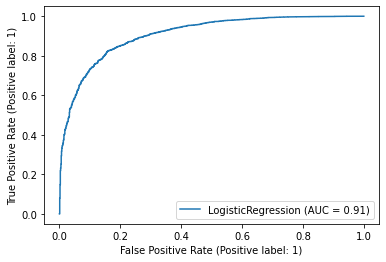

In [140]:
plot_roc_curve(logit_best, X_test_transformed, y_test)
plt.show()

In [141]:
# Calculate F1 Score of tuned model using weighted average method
f1_logit_tuned_smote_train = f1_score(y_train_sm, y_pred_train, average="weighted")

f1_logit_tuned_smote_test = f1_score(y_test, y_pred_test, average="weighted")

In [142]:
logit_tuned_smote_dict = {'Model':'logit_tuned_smote',
    'f1_score_train':round(f1_logit_tuned_smote_train,2),
    'f1_score_test':round(f1_logit_tuned_smote_test,2)}
    
classification_model_performance = classification_model_performance.append(logit_tuned_smote_dict,ignore_index=True)
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87
1,logit_untuned_smote,0.97,0.90
2,logit_tuned_smote,1.00,0.91


###    2.2.1. Building the Random forest model with hyperparameter tuning after handling class imbalance:

In [143]:
# Creating an instance of class RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True, oob_score=True)

In [144]:
# hyperparameter values for tuning with GridSearch cross validation:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [145]:
# GridSearch cross validation with 4 folds for Hyperparameter tuning:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1_weighted")

In [146]:
%%time
grid_search.fit(X_train_transformed_sm, y_train_sm)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Wall time: 51 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1_weighted', verbose=1)

In [147]:
# best weighted f1 score after performing gridsearchCV:
grid_search.best_score_

0.8322266329282676

In [148]:
# Getting the best estimator:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       oob_score=True, random_state=42)

In [149]:
# Inspecting out of bag score:
rf_best.oob_score_

0.8316616605878567

In [150]:
# Prediction Train Data
y_pred_train= rf_best.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("Random forest accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Random forest accuracy 0.8559858399485089
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     16338
           1       0.92      0.82      0.86     20950

    accuracy                           0.86     37288
   macro avg       0.86      0.86      0.86     37288
weighted avg       0.86      0.86      0.86     37288



In [151]:
# Prediction Test Data
y_pred_test = rf_best.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Random forest accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Random forest accuracy 0.8656666666666667
              precision    recall  f1-score   support

           0       0.44      0.41      0.43      1094
           1       0.92      0.93      0.92      7906

    accuracy                           0.87      9000
   macro avg       0.68      0.67      0.67      9000
weighted avg       0.86      0.87      0.86      9000

[[ 448  646]
 [ 563 7343]]


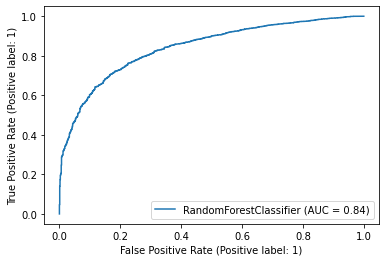

In [152]:
plot_roc_curve(rf_best, X_test_transformed, y_test)
plt.show()

In [153]:
# Calculate F1 Score of tuned model using weighted average method
f1_RF_tuned_smote_train = f1_score(y_train_sm, y_pred_train, average="weighted")

f1_RF_tuned_smote_test = f1_score(y_test, y_pred_test, average="weighted")

In [154]:
RF_tuned_smote_dict = {'Model':'RF_tuned_smote',
    'f1_score_train':round(f1_RF_tuned_smote_train,2),
    'f1_score_test':round(f1_RF_tuned_smote_test,2)}
    
classification_model_performance = classification_model_performance.append(RF_tuned_smote_dict,ignore_index=True)
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87
1,logit_untuned_smote,0.97,0.90
2,logit_tuned_smote,1.00,0.91
3,RF_tuned_smote,0.86,0.87


###    2.3.1. Building the naive bayes model with hyperparameter tuning after handling class imbalance:

In [155]:
# Building the NB classifier model
mnb = MultinomialNB()

In [156]:
# hyperparameter values for tuning with GridSearch cross validation:
params = {'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 10.0]}

In [157]:
# GridSearch cross validation with 4 folds for Hyperparameter tuning:
grid_search = GridSearchCV(estimator=mnb,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1_weighted")

In [158]:
%%time
grid_search.fit(X_train_transformed_sm, y_train_sm)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Wall time: 301 ms


GridSearchCV(cv=4, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_weighted', verbose=1)

In [159]:
# best weighted f1 score after performing gridsearchCV:
grid_search.best_score_

0.972480640823432

In [160]:
# Getting the best estimator:
mnb_best = grid_search.best_estimator_
mnb_best

MultinomialNB(alpha=0.001)

In [161]:
# Prediction Train Data
y_pred_train= mnb_best.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("Naive bayes accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Naive bayes accuracy 0.9825949367088608
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18781
           1       0.98      0.99      0.98     18507

    accuracy                           0.98     37288
   macro avg       0.98      0.98      0.98     37288
weighted avg       0.98      0.98      0.98     37288



In [162]:
# Prediction Test Data
y_pred_test = mnb_best.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Naive bayes accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Naive bayes accuracy 0.891
              precision    recall  f1-score   support

           0       0.33      0.52      0.41       646
           1       0.96      0.92      0.94      8354

    accuracy                           0.89      9000
   macro avg       0.65      0.72      0.67      9000
weighted avg       0.92      0.89      0.90      9000

[[ 338  308]
 [ 673 7681]]


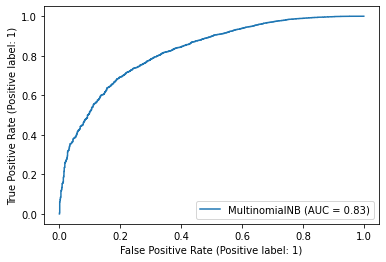

In [163]:
plot_roc_curve(mnb_best, X_test_transformed, y_test)
plt.show()

In [164]:
# Calculate F1 Score of tuned model using weighted average method
f1_NB_tuned_smote_train = f1_score(y_train_sm, y_pred_train, average="weighted")

f1_NB_tuned_smote_test = f1_score(y_test, y_pred_test, average="weighted")

In [165]:
NB_tuned_smote_dict = {'Model':'NB_tuned_smote',
    'f1_score_train':round(f1_NB_tuned_smote_train,2),
    'f1_score_test':round(f1_NB_tuned_smote_test,2)}
    
classification_model_performance = classification_model_performance.append(NB_tuned_smote_dict,ignore_index=True)
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87
1,logit_untuned_smote,0.97,0.90
2,logit_tuned_smote,1.00,0.91
3,RF_tuned_smote,0.86,0.87
4,NB_tuned_smote,0.98,0.88


###    2.4.1. Building the XGBOOST classifier model with hyperparameter tuning after handling class imbalance:

In [166]:
# Creating an instance of class XGBClassifier:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = "binary:logistic",eval_metric='logloss')

In [167]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'max_depth': [3, 5, 10, 15]
        }

folds = 4


# Random search cross validation with 4 folds for Hyperparameter tuning:
random_search = RandomizedSearchCV(
        xgb_cfl,
        param_distributions=params,
        scoring='f1_weighted',
        n_jobs=-1,
        cv=folds, verbose=1, random_state=42)

In [168]:
%%time
random_search.fit(X_train_transformed_sm, y_train_sm)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Wall time: 5min 21s


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [169]:
# best weighted f1 score after performing RandomizedSearchCV:
random_search.best_score_

0.9384568402989579

In [170]:
# Getting the best estimator:
xgboost_best = random_search.best_estimator_
xgboost_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='logloss', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [171]:
# Prediction Train Data
y_pred_train= xgboost_best.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("XGBOOST accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

XGBOOST accuracy 0.9827826646642351
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18562
           1       0.98      0.98      0.98     18726

    accuracy                           0.98     37288
   macro avg       0.98      0.98      0.98     37288
weighted avg       0.98      0.98      0.98     37288



In [172]:
# Prediction Test Data
y_pred_test = xgboost_best.predict(X_test_transformed)

#Model Performance on Test Dataset
print("XGBOOST accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

XGBOOST accuracy 0.9114444444444444
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       818
           1       0.96      0.94      0.95      8182

    accuracy                           0.91      9000
   macro avg       0.74      0.79      0.76      9000
weighted avg       0.92      0.91      0.92      9000

[[ 516  302]
 [ 495 7687]]


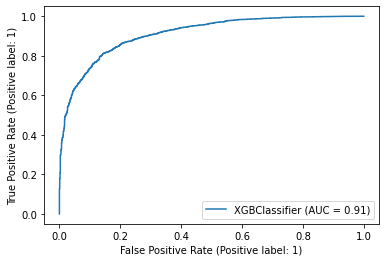

In [173]:
plot_roc_curve(xgboost_best, X_test_transformed, y_test)
plt.show()

In [174]:
# Calculate F1 Score of tuned model using weighted average method
f1_XGBOOST_tuned_smote_train = f1_score(y_train_sm, y_pred_train, average="weighted")

f1_XGBOOST_tuned_smote_test = f1_score(y_test, y_pred_test, average="weighted")

In [175]:
XGBOOST_tuned_smote_dict = {'Model':'XGBOOST_tuned_smote',
    'f1_score_train':round(f1_XGBOOST_tuned_smote_train,2),
    'f1_score_test':round(f1_XGBOOST_tuned_smote_test,2)}
    
classification_model_performance = classification_model_performance.append(XGBOOST_tuned_smote_dict,ignore_index=True)
classification_model_performance

,Model,f1_score_train,f1_score_test
0,logit_untuned,0.89,0.87
1,logit_untuned_smote,0.97,0.90
2,logit_tuned_smote,1.00,0.91
3,RF_tuned_smote,0.86,0.87
4,NB_tuned_smote,0.98,0.88
5,XGBOOST_tuned_smote,0.98,0.91


## Conclusion:
Although XGBOOST is giving partially better performance, we will not use it since it is very heavy model to deploy. Hence, We will use logistic regression for sentiment classification as it is giving good results as compared to random forest and naive bayes models and it is lighter to deploy as compared to XGBOOST.

Saving Logit classifier model with the help of pickle:

In [176]:
with open('./Model/SentimentClassification_logit.pkl', 'wb') as file_3:
    pickle.dump(logit_best, file_3)

## End to end flow for getting top 4 recommendation for a particular user:

In [177]:
with open('Model/recommendation_UBCF.pkl', 'rb') as file:
    recomendation_matrix = pickle.load(file)

In [178]:
with open('Model/tfidf_vectorizer.pkl', 'rb') as file:
    word_vectorizer = pickle.load(file)

In [179]:
with open('Model/SentimentClassification_logit.pkl', 'rb') as file:
    SentimentClassification_logit = pickle.load(file)

In [180]:
user_input = input("Enter your user name")
recomended_20 = recomendation_matrix.loc[user_input].sort_values(ascending=False)[0:20]
recomended_20_names = recomended_20.index

In [181]:
recomended_20_names

Index(['Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'Red (special Edition) (dvdvideo)',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
       'Clorox Disinfecting Bathroom Cleaner',
       '100:Complete First Season (blu-Ray)',
       'Chester's Cheese Flavored Puffcorn Snacks',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Coty Airspun Face Powder, Translucent Extra Coverage',
       'Tostitos Bite Size Tortilla Chips', 'Jason Aldean - They Don't Know',
       'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
       'Hormel Chili, No Beans',
       'Caress Moisturizing Body Bar Natural Silk, 4.75oz',
       'Burt's Bees Lip Shimmer, Raisin',
       'Just For Men Touch Of Gray Gray Hair Treatment, Black T-55',
       'Th

In [182]:
# recomended_20_df = review_filtered[review_filtered.name.isin(recomended_20_names)].copy(deep=True)

In [183]:
recomended_20_df = review_filtered[review_filtered.name.isin(recomended_20_names)]

In [184]:
X_reviews = word_vectorizer.transform(recomended_20_df['combined_txt'].tolist())

In [185]:
Y_sentiment_prediction = SentimentClassification_logit.predict(X_reviews)

In [186]:
recomended_20_df['sentiment_predicted'] = pd.Series(Y_sentiment_prediction)

In [187]:
product_sentiment_dict = {}

In [188]:
for product in recomended_20_names:
    total_positive_reviews = recomended_20_df[recomended_20_df.name == product]['sentiment_predicted'].sum()
    total_product_reviews = recomended_20_df[recomended_20_df.name == product]['sentiment_predicted'].index.nunique()
    positive_sentiment_percent = round((total_positive_reviews / total_product_reviews) * 100,2)
    product_sentiment_dict[product] = positive_sentiment_percent

In [189]:
top_4_recomended = sorted(product_sentiment_dict.items(), key=lambda item: item[1],reverse=True)[:4]

In [190]:
top_4_recomended

[('Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)', 97.98),
 ('Coty Airspun Face Powder, Translucent Extra Coverage', 94.94),
 ('Just For Men Touch Of Gray Gray Hair Treatment, Black T-55', 92.41),
 ('Hormel Chili, No Beans', 92.35)]

In [191]:
pd.DataFrame(top_4_recomended,columns=['Product','Sentimen(%)'],index=np.arange(1, len(top_4_recomended)+1))

,Product,Sentimen(%)
1,Dark Shadows (includes Digital Copy) (ultravio...,97.98
2,"Coty Airspun Face Powder, Translucent Extra Co...",94.94
3,Just For Men Touch Of Gray Gray Hair Treatment...,92.41
4,"Hormel Chili, No Beans",92.35


# THE END.